In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

import multirtd.params as params
from multirtd.utils import plot_environment
from multirtd.planners.dubins_planner import DubinsPlanner

from multirtd.dynamics.diff_drive_dynamics import DiffDriveDynamics
from multirtd.sensors.position_sensor import PositionSensor
from multirtd.controllers.lqr_controller import LQRController
from multirtd.estimators.ekf import EKF
from multirtd.turtlebot import Turtlebot

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

Test scenario with obstacles

In [3]:
x0 = np.array([-5, 0, 0])

planner = DubinsPlanner()
# Set planner goal and obstacles
planner.p_goal = np.array([5, 0])
# (center, radius) tuples
obs_R = 1.5
planner.obstacles = [(np.array([3, 1]), obs_R),
                     (np.array([0, -1.5]), obs_R),
                     (np.array([-3, 1]), obs_R)]

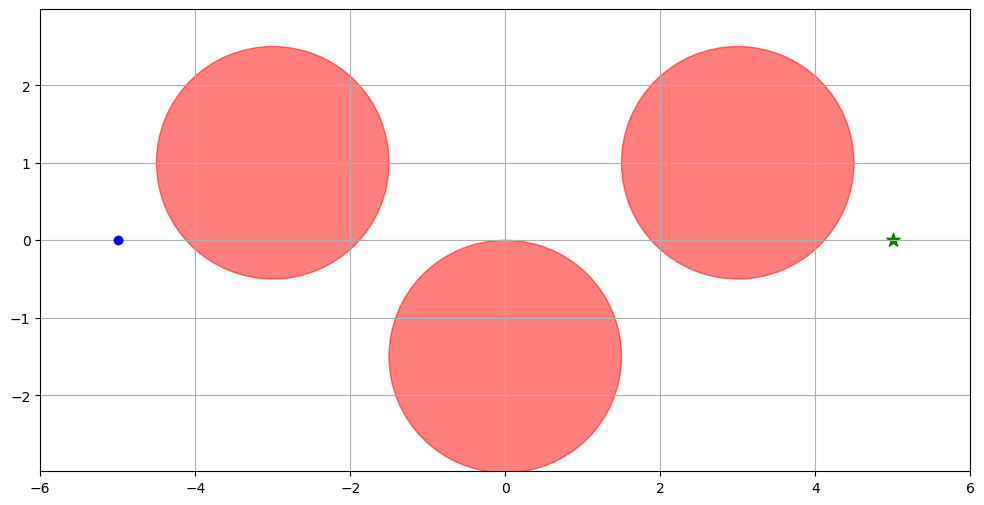

In [4]:
ax = plot_environment(planner.obstacles, None, x0, planner.p_goal)
ax.set_xlim((-6, 6))
ax.set_ylim((-3, 3))
plt.show()

In [ ]:
#%lprun -f planner.traj_opt_sample planner.traj_opt_sample(np.zeros(3), 0)

In [16]:
turtlebot = Turtlebot(x0=x0)
turtlebot.dynamics.sigma = 0.0
turtlebot.sensor.sigma = 0.01

done = False

while not done:
    print("Current state: " + str(turtlebot.x))

    # Replan trajectory of length N=31
    x_nom, u_nom = planner.replan(turtlebot.estimator.x_est)

    # Track the trajectory for N=5 timesteps (i.e. replan every 0.5 seconds)
    turtlebot.track(x_nom[:5], u_nom[:5])

    if np.linalg.norm(turtlebot.x[:-1] - planner.p_goal) < params.R_GOAL_REACHED:
        print("Goal reached")
        done = True

Current state: [-5  0  0]
Current state: [-4.90359974e+00 -1.59686456e-03 -4.53641110e-02]
Current state: [-4.8106712  -0.00807505 -0.10895605]
Current state: [-4.7178187  -0.02050846 -0.17330711]
Current state: [-4.62670666 -0.0387708  -0.23767062]
Current state: [-4.53612307 -0.06311361 -0.3036745 ]
Current state: [-4.44807673 -0.09345022 -0.38047552]
Current state: [-4.36226613 -0.13130885 -0.47419697]
Current state: [-4.28113053 -0.175814   -0.54596655]
Current state: [-4.20222092 -0.22643824 -0.61020032]
Current state: [-4.12607814 -0.28073882 -0.63500725]
Current state: [-4.05052798 -0.33834484 -0.67934408]
No feasible plan found
Failed to find new plan


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
turtlebot = Turtlebot(x0=x0)
turtlebot.sigma = 0.0

controller_hz = 10
planner_hz = 2

t_sim = 0
planning_times = []

done = False
pbar = tqdm()
while not done:
    
    if t_sim % int(controller_hz/planner_hz) == 0:
        start_time = time.time()
        u = planner.traj_opt_sample(turtlebot.x, 0)
        planning_times.append(time.time() - start_time)

    turtlebot.step(u)
    #print(turtlebot.x)
    t_sim += 1

    if np.linalg.norm(turtlebot.x[:-1] - planner.p_goal) < params.R_GOAL_REACHED:
        print("Goal reached")
        done = True
    
    #pbar.update(t_sim)
    pbar.set_description(f"Current x = {turtlebot.x}")

print("Avg planning time = ", np.mean(planning_times), " seconds")

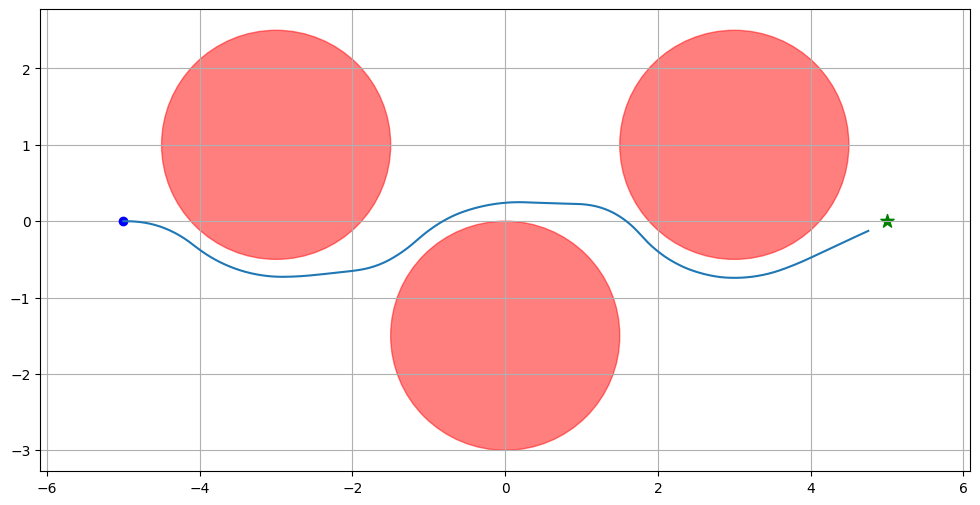

In [15]:
traj = np.stack(turtlebot.x_hist)[:,:-1]

ax = plot_environment(planner.obstacles, None, x0, planner.p_goal)

ax.plot(traj[:,0], traj[:,1])
# for i in range(len(traj)):
#     ax.add_patch(plt.Circle(tuple(traj[i]), params.R_BOT, color='b', alpha=0.02))

plt.show()

Test scenario with multiple obstacles and uncertainty regions

In [ ]:
#planner.obstacles = [(np.array([0, 0]), 1.0)]
planner.obstacles = []

# Uncertainty region
unc_regions = [(np.array([0, 0]), 2.0)]

In [ ]:
# Visualize setup
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim((-6, 6))
ax.set_ylim((-3, 3))
ax.grid()

ax.add_patch(plt.Circle(tuple(x0[:-1]), params.R_BOT, color='b'))
ax.scatter(planner.p_goal[0], planner.p_goal[1], s=100, marker='*', color='g')

# Single obstacle with uncertainty region around it
for obs in planner.obstacles:
    ax.add_patch(plt.Circle(tuple(obs[0]), obs[1], color='r', alpha=0.5))

for reg in unc_regions:
    ax.add_patch(plt.Circle(tuple(reg[0]), reg[1], color='r', alpha=0.1))

plt.show()

In [ ]:
def check_in_regions(x, regs):
    for reg in regs:
        if np.linalg.norm(x - reg[0]) < reg[1]:
            return True
    return False

In [ ]:
turtlebot = Turtlebot(x0=x0)
turtlebot.sigma = 0.01

controller_hz = 10
planner_hz = 2

t_sim = 0
planning_times = []

done = False
pbar = tqdm()
while not done:

    if check_in_regions(turtlebot.x[:-1], unc_regions):
        turtlebot.sigma = 0.1
    else:
        turtlebot.sigma = 0.01
    
    if t_sim % int(controller_hz/planner_hz) == 0:
        start_time = time.time()
        u = planner.traj_opt_sample(turtlebot.x, 0)
        planning_times.append(time.time() - start_time)

    turtlebot.step(u)
    #print(turtlebot.x)
    t_sim += 1

    if np.linalg.norm(turtlebot.x[:-1] - planner.p_goal) < params.R_GOAL_REACHED:
        print("Goal reached")
        done = True
    
    pbar.update(t_sim)

print("Avg planning time = ", np.mean(planning_times), " seconds")

In [ ]:
traj = np.stack(turtlebot.x_hist)[:,:-1]

# Visualize setup
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim((-6, 6))
ax.set_ylim((-3, 3))
ax.grid()

ax.add_patch(plt.Circle(tuple(x0[:-1]), params.R_BOT, color='b'))
ax.scatter(planner.p_goal[0], planner.p_goal[1], s=100, marker='*', color='g')

# Single obstacle with uncertainty region around it
for obs in planner.obstacles:
    ax.add_patch(plt.Circle(tuple(obs[0]), obs[1], color='r', alpha=0.5))

for reg in unc_regions:
    ax.add_patch(plt.Circle(tuple(reg[0]), reg[1], color='r', alpha=0.1))

ax.plot(traj[:,0], traj[:,1])
for i in range(len(traj)):
    ax.add_patch(plt.Circle(tuple(traj[i]), params.R_BOT, color='b', alpha=0.02))

plt.show()

Test planner with closed loop feedback

In [ ]:
dynamics = DiffDriveDynamics(sigma=0.01)
sensor = PositionSensor(n=2, sigma=0.1)
controller = LQRController(dynamics)
estimator = EKF(dynamics, sensor)

In [ ]:
# Re-plan: compute u
# Control: apply u with feedback. get measurement and update x_est

In [ ]:
turtlebot = Turtlebot(x0=x0, dynamics=dynamics, sensor=sensor, controller=controller, estimator=estimator)

planner.p_goal = np.array([2, 2])

turtlebot.sigma = 0.01

controller_hz = 10
planner_hz = 2

t_sim = 0
planning_times = []

done = False
pbar = tqdm()
while not done:
    
    if t_sim % int(controller_hz/planner_hz) == 0:
        start_time = time.time()
        u = planner.traj_opt_sample(turtlebot.x, 0)
        planning_times.append(time.time() - start_time)

    turtlebot.step(u)
    #print(turtlebot.x)
    t_sim += 1

    if np.linalg.norm(turtlebot.x[:-1] - planner.p_goal) < params.R_GOAL_REACHED:
        print("Goal reached")
        done = True
    
    pbar.update(t_sim)

print("Avg planning time = ", np.mean(planning_times), " seconds")

In [ ]:
np.random.normal(0, 0.01, 2)

In [ ]:
traj = np.stack(turtlebot.x_hist)[:,:-1]

ax = plot_environment(None, None, x0, planner.p_goal)
ax.axis('equal')
ax.plot(traj[:,0], traj[:,1])

plt.show()